<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork26802033-2022-01-01">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Space X  Falcon 9 First Stage Landing Prediction**


## Assignment:  Machine Learning Prediction


Estimated time needed: **60** minutes


Space X advertises Falcon 9 rocket launches on its website with a cost of 62 million dollars; other providers cost upward of 165 million dollars each, much of the savings is because Space X can reuse the first stage. Therefore if we can determine if the first stage will land, we can determine the cost of a launch. This information can be used if an alternate company wants to bid against space X for a rocket launch.   In this lab, you will create a machine learning pipeline  to predict if the first stage will land given the data from the preceding labs.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/landing_1.gif)


Several examples of an unsuccessful landing are shown here:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/api/Images/crash.gif)


Most unsuccessful landings are planed. Space X; performs a controlled landing in the oceans.


## Objectives


Perform exploratory  Data Analysis and determine Training Labels

*   create a column for the class
*   Standardize the data
*   Split into training data and test data

\-Find best Hyperparameter for SVM, Classification Trees and Logistic Regression

*   Find the method performs best using test data


## Import Libraries and Define Auxiliary Functions


In [1]:
import piplite
await piplite.install(['numpy'])
await piplite.install(['pandas'])
await piplite.install(['seaborn'])

We will import the following libraries for the lab


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

This function is to plot the confusion matrix.


In [34]:
def plot_confusion_matrix(y,y_predict):
    "this function plots the confusion matrix"
    from sklearn.metrics import confusion_matrix

    cm = confusion_matrix(y, y_predict)
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax); #annot=True to annotate cells
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix'); 
    ax.xaxis.set_ticklabels(['did not land', 'land']); ax.yaxis.set_ticklabels(['did not land', 'landed']) 
    plt.show() 

## Load the dataframe


Load the data


In [4]:
from js import fetch
import io


#original data
URL1 = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_2.csv"
resp1 = await fetch(URL1)
text1 = io.BytesIO((await resp1.arrayBuffer()).to_py())
data = pd.read_csv(text1)

In [5]:
data.head()

,FlightNumber,Date,BoosterVersion,PayloadMass,Orbit,LaunchSite,Outcome,Flights,GridFins,Reused,Legs,LandingPad,Block,ReusedCount,Serial,Longitude,Latitude,Class
0,1,2010-06-04,Falcon 9,6104.959412,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0003,-80.577366,28.561857,0
1,2,2012-05-22,Falcon 9,525.000000,LEO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0005,-80.577366,28.561857,0
2,3,2013-03-01,Falcon 9,677.000000,ISS,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B0007,-80.577366,28.561857,0
3,4,2013-09-29,Falcon 9,500.000000,PO,VAFB SLC 4E,False Ocean,1,False,False,False,NaN,1.0,0,B1003,-120.610829,34.632093,0
4,5,2013-12-03,Falcon 9,3170.000000,GTO,CCAFS SLC 40,None None,1,False,False,False,NaN,1.0,0,B1004,-80.577366,28.561857,0


In [6]:
#data after one hot encoding
URL2 = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-DS0321EN-SkillsNetwork/datasets/dataset_part_3.csv'
resp2 = await fetch(URL2)
text2 = io.BytesIO((await resp2.arrayBuffer()).to_py())
X = pd.read_csv(text2)

In [7]:
X.head(100)

,FlightNumber,PayloadMass,Flights,Block,ReusedCount,Orbit_ES-L1,Orbit_GEO,Orbit_GTO,Orbit_HEO,Orbit_ISS,...,Serial_B1058,Serial_B1059,Serial_B1060,Serial_B1062,GridFins_False,GridFins_True,Reused_False,Reused_True,Legs_False,Legs_True
0,1.0,6104.959412,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,2.0,525.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,3.0,677.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,4.0,500.000000,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,5.0,3170.000000,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,86.0,15400.000000,2.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
86,87.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
87,88.0,15400.000000,6.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0
88,89.0,15400.000000,3.0,5.0,2.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0


## TASK  1


Create a NumPy array from the column <code>Class</code> in <code>data</code>, by applying the method <code>to_numpy()</code>  then
assign it  to the variable <code>Y</code>,make sure the output is a  Pandas series (only one bracket df\['name of  column']).


In [8]:
y = data['Class'].to_numpy()
y

array([0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1], dtype=int64)

## TASK  2


Standardize the data in <code>X</code> then reassign it to the variable  <code>X</code> using the transform provided below.


In [9]:
# students get this 
transform = preprocessing.StandardScaler()
X = transform.fit_transform(X)

We split the data into training and testing data using the  function  <code>train_test_split</code>.   The training data is divided into validation data, a second set used for training  data; then the models are trained and hyperparameters are selected using the function <code>GridSearchCV</code>.


## TASK  3


Use the function train_test_split to split the data X and Y into training and test data. Set the parameter test_size to  0.2 and random_state to 2. The training data and test data should be assigned to the following labels.


<code>X_train, X_test, Y_train, Y_test</code>


In [10]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size = 0.2, random_state = 2)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(72, 83) (18, 83) (72,) (18,)


we can see we only have 18 test samples.


In [11]:
Y_test.shape

(18,)

## TASK  4


Create a logistic regression object  then create a  GridSearchCV object  <code>logreg_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [12]:
parameters ={"C":[0.01,0.1,1],'penalty':['l2'], 'solver':['lbfgs']}# l1 lasso l2 ridge
lr=LogisticRegression()

We output the <code>GridSearchCV</code> object for logistic regression. We display the best parameters using the data attribute <code>best_params\_</code> and the accuracy on the validation data using the data attribute <code>best_score\_</code>.


In [13]:
logreg_cv = GridSearchCV(lr, parameters, scoring='accuracy', cv=10).fit(X_train, Y_train)

print("tuned hpyerparameters :(best parameters) ",logreg_cv.best_params_)
print("accuracy :",logreg_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
accuracy : 0.8464285714285713


## TASK  5


Calculate the accuracy on the test data using the method <code>score</code>:


In [14]:
logreg_cv.score(X_test, Y_test)

0.8333333333333334

Lets look at the confusion matrix:


In [15]:
yhat=logreg_cv.predict(X_test)

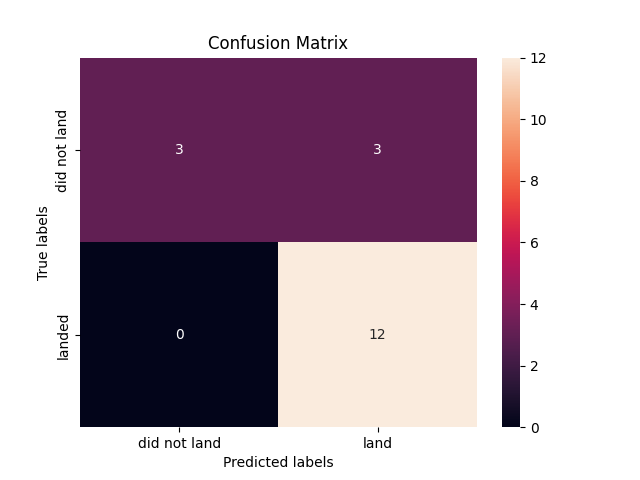

In [16]:

plot_confusion_matrix(Y_test,yhat)

/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


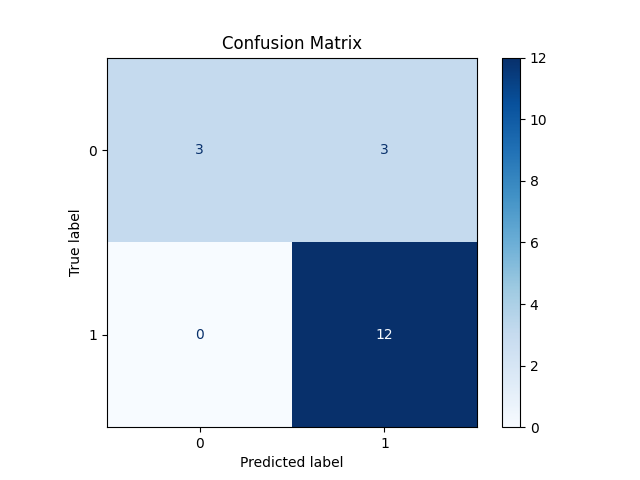

In [17]:
# or we can use plot_confusion_matrix from sklearn even without the defined function

from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(Y_test, yhat, labels=[1,0])

labels = ['landed', 'did not land']
plot_confusion_matrix(logreg_cv, X_test, Y_test, cmap='Blues')
plt.title('Confusion Matrix')

plt.show()

Examining the confusion matrix, we see that logistic regression can distinguish between the different classes.  We see that the major problem is false positives.


## TASK  6


Create a support vector machine object then  create a  <code>GridSearchCV</code> object  <code>svm_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [18]:
parameters = {'kernel':('linear', 'rbf','poly','rbf', 'sigmoid'),
              'C': np.logspace(-3, 3, 5),
              'gamma':np.logspace(-3, 3, 5)}
svm = SVC()

In [19]:
svm_cv = GridSearchCV(svm, parameters, scoring='accuracy', cv=10).fit(X_train, Y_train)

In [20]:
print("tuned hpyerparameters :(best parameters) ",svm_cv.best_params_)
print("accuracy :",svm_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'C': 1.0, 'gamma': 0.03162277660168379, 'kernel': 'sigmoid'}
accuracy : 0.8482142857142856


## TASK  7


Calculate the accuracy on the test data using the method <code>score</code>:


In [21]:
svm_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


In [22]:
yhat=svm_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

/lib/python3.10/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


<class 'TypeError'>: plot_confusion_matrix() missing 1 required positional argument: 'y_true'

## TASK  8


Create a decision tree classifier object then  create a  <code>GridSearchCV</code> object  <code>tree_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [23]:
parameters = {'criterion': ['gini', 'entropy'],
     'splitter': ['best', 'random'],
     'max_depth': [2*n for n in range(1,10)],
     'max_features': ['auto', 'sqrt'],
     'min_samples_leaf': [1, 2, 4],
     'min_samples_split': [2, 5, 10]}

tree = DecisionTreeClassifier()

In [24]:
tree_cv = GridSearchCV(tree, parameters, scoring = 'accuracy', cv = 10).fit(X_train, Y_train)


In [25]:
print("tuned hpyerparameters :(best parameters) ",tree_cv.best_params_)
print("accuracy :",tree_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'criterion': 'entropy', 'max_depth': 8, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 10, 'splitter': 'best'}
accuracy : 0.8875


## TASK  9


Calculate the accuracy of tree_cv on the test data using the method <code>score</code>:


In [26]:
tree_cv.score(X_test, Y_test)

0.9444444444444444

We can plot the confusion matrix


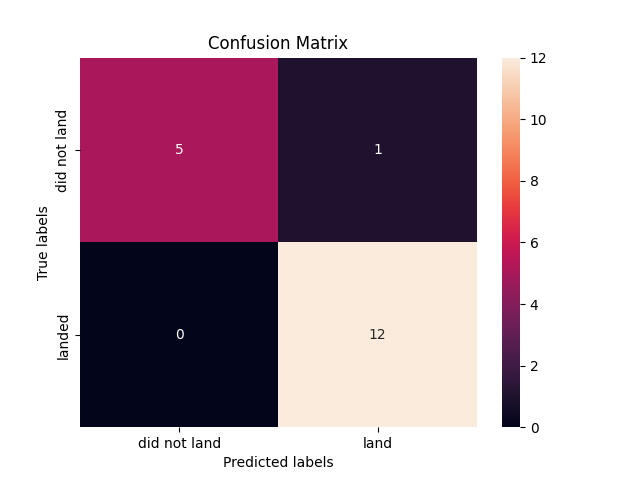

In [35]:
yhat = tree_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  10


Create a k nearest neighbors object then  create a  <code>GridSearchCV</code> object  <code>knn_cv</code> with cv = 10.  Fit the object to find the best parameters from the dictionary <code>parameters</code>.


In [36]:
parameters = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
              'p': [1,2]}

KNN = KNeighborsClassifier()

In [37]:
knn_cv = GridSearchCV(KNN, parameters, scoring = 'accuracy', cv=10).fit(X_train, Y_train)


In [38]:
print("tuned hpyerparameters :(best parameters) ",knn_cv.best_params_)
print("accuracy :",knn_cv.best_score_)

tuned hpyerparameters :(best parameters)  {'algorithm': 'auto', 'n_neighbors': 10, 'p': 1}
accuracy : 0.8482142857142858


## TASK  11


Calculate the accuracy of knn_cv on the test data using the method <code>score</code>:


In [39]:
knn_cv.score(X_test, Y_test)

0.8333333333333334

We can plot the confusion matrix


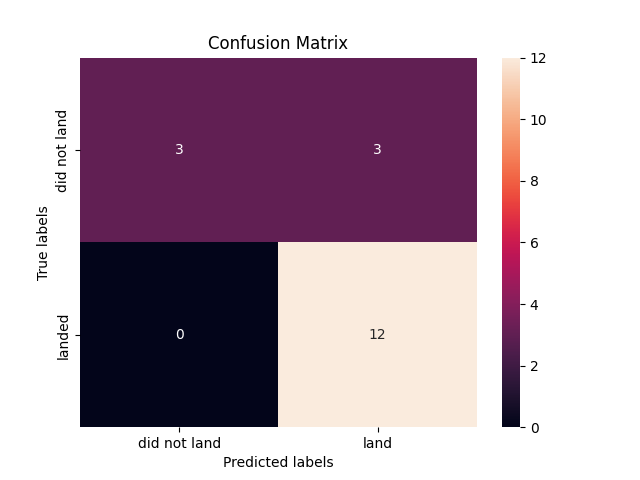

In [40]:
yhat = knn_cv.predict(X_test)
plot_confusion_matrix(Y_test,yhat)

## TASK  12


Find the method performs best:


In [41]:
print('Accuracy for Logistics Regression method:', logreg_cv.score(X_test, Y_test))
print( 'Accuracy for Support Vector Machine method:', svm_cv.score(X_test, Y_test))
print('Accuracy for Decision tree method:', tree_cv.score(X_test, Y_test))
print('Accuracy for K nearsdt neighbors method:', knn_cv.score(X_test, Y_test))

Accuracy for Logistics Regression method: 0.8333333333333334
Accuracy for Support Vector Machine method: 0.8333333333333334
Accuracy for Decision tree method: 0.9444444444444444
Accuracy for K nearsdt neighbors method: 0.8333333333333334


***Now we want to plot a bar chart to visualize the accuracy of each model***

In [48]:
accuracy_df = pd.DataFrame({'Logistic Regression':logreg_cv.score(X_test, Y_test), 
                           'SVM':svm_cv.score(X_test, Y_test),
                           'Decision tree':tree_cv.score(X_test, Y_test),
                           'KNN':knn_cv.score(X_test, Y_test)}, index=['Accuracy']).T
accuracy_df

,Accuracy
Logistic Regression,0.833333
SVM,0.833333
Decision tree,0.944444
KNN,0.833333


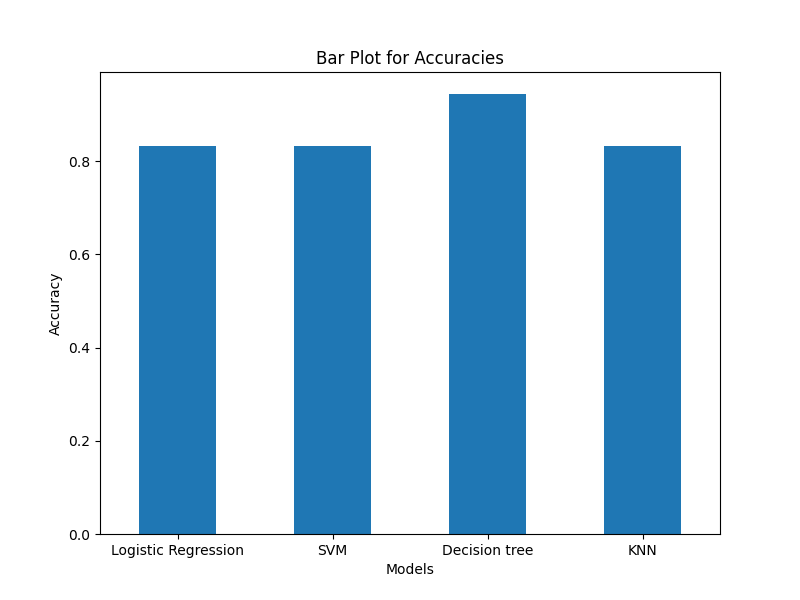

In [72]:
plt.figure(figsize=(8,6))
accuracy_df['Accuracy'].plot.bar()
plt.title('Bar Plot for Accuracies')
plt.xlabel('Models')
plt.xticks(rotation = 'horizontal')
plt.ylabel('Accuracy')
plt.show()

***Calculate the prediction of average successful landing rate***

In [86]:
predicted_probabilities = tree_cv.predict_proba(X_test)
avg_prob = predicted_probabilities[:, 1].mean()
avg_prob

0.6895061728395061

***Finally, calculating the cost of each launch with the competing price of 62 million***

In [85]:
compete_cost = 62000000
target_cost = avg_prob * compete_cost
target_cost

42749382.71604938

if we can control the cost to 42749382.72 per launch, the imaginary company, SpaceY, will be able to compete with SpaceX on the average cost of 62 million per launch

## Authors


[Pratiksha Verma](https://www.linkedin.com/in/pratiksha-verma-6487561b1/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMDS0321ENSkillsNetwork865-2023-01-01)


## Change Log


| Date (YYYY-MM-DD) | Version | Changed By      | Change Description      |
| ----------------- | ------- | -------------   | ----------------------- |
| 2022-11-09        | 1.0     | Pratiksha Verma | Converted initial version to Jupyterlite|


### <h3 align="center"> IBM Corporation 2022. All rights reserved. <h3/>
